# Hyperparameter Importance and Interactions an Example with Decision Trees (Scikit-Learn)

In this tutorial, we will see how to use Hyperparameter optimization to improve the accuarcy of a decision tree classifier. Then,
we will study the importance and interaction of hyperparameters.

In [1]:
import matplotlib.pyplot as plt

WIDTH_PLOTS = 8
HEIGHT_PLOTS = WIDTH_PLOTS / 1.618

## Data

For the data, we use the ``make_moons`` functionality from Scikit-Learn to have a binary-classification problem.

In addition, we randomly flip 10% of the labels to generate artificial noise (later corresponding to aleatoric uncertainty).

In [2]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split


# Dataset
def flip_binary_labels(y, ratio, random_state=None):
    """Increase the variance of P(Y|X) by ``ratio``"""
    y_flipped = np.zeros(np.shape(y))
    y_flipped[:] = y[:]
    rs = np.random.RandomState(random_state)
    idx = np.arange(len(y_flipped))
    idx = rs.choice(idx, size=int(ratio * len(y_flipped)), replace=False)
    y_flipped[idx] = 1 - y_flipped[idx]
    return y_flipped


def load_data_train_test(random_state=42):
    noise = 0.1
    n = 1_000
    ratio_flipped = 0.1  # 10% of the labels are flipped

    rng = np.random.RandomState(random_state)

    # Moons
    make_dataset = lambda n, seed: make_moons(
        n_samples=n,
        noise=noise,
        shuffle=True,
        random_state=seed,
    )

    X, y = make_dataset(n, rng.randint(2**31))
    center = np.mean(X, axis=0)
    X = X - center

    y = flip_binary_labels(y, ratio=ratio_flipped, random_state=rng.randint(2**31))
    y = y.astype(np.int64)

    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=0.33, random_state=rng.randint(2**31), stratify=y
    )

    return (train_X, train_y), (test_X, test_y)


def load_data_train_valid(verbose=0, random_state=42):

    (x, y), _ = load_data_train_test(random_state=random_state)

    train_X, valid_X, train_y, valid_y = train_test_split(
        x, y, test_size=0.33, random_state=random_state, stratify=y
    )

    if verbose:
        print(f"train_X shape: {np.shape(train_X)}")
        print(f"train_y shape: {np.shape(train_y)}")
        print(f"valid_X shape: {np.shape(valid_X)}")
        print(f"valid_y shape: {np.shape(valid_y)}")
    return (train_X, train_y), (valid_X, valid_y)

train_X shape: (448, 2)
train_y shape: (448,)
valid_X shape: (222, 2)
valid_y shape: (222,)


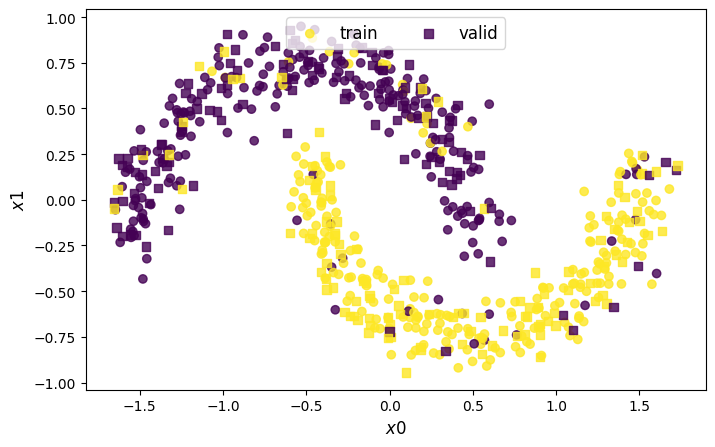

In [3]:
(x, y), (vx, vy) = load_data_train_valid(verbose=1)
_, (tx, ty) = load_data_train_test()

plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

plt.scatter(
    x[:, 0].reshape(-1), x[:, 1].reshape(-1), c=y, label="train", alpha=0.8
)
plt.scatter(
    vx[:, 0].reshape(-1),
    vx[:, 1].reshape(-1),
    c=vy,
    marker="s",
    label="valid",
    alpha=0.8,
)

plt.ylabel("$x1$", fontsize=12)
plt.xlabel("$x0$", fontsize=12)

plt.legend(loc="upper center", ncol=3, fontsize=12)

plt.show()


## Training and Scoring of Decision Tree

The class of model we use in this tutorial is Decision Tree.

In this part, we will see how to train and evaluate such models.

In [4]:
def plot_decision_boundary_decision_tree(dataset, labels, model, steps=1000, color_map="viridis"):
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    labels_predicted = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Plot decision boundary in region of interest
    z = labels_predicted[:, 1].reshape(xx.shape)

    ax = plt.gca()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)

    # Get predicted labels on training data and plot
    ax.scatter(
        dataset[:, 0],
        dataset[:, 1],
        c=labels,
        # cmap=color_map,
        lw=0,
    )
    plt.show()

In [17]:
import pathlib
import pickle
import os

from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import log_loss, accuracy_score
from sklearn.tree import DecisionTreeClassifier

hpo_dir = "hpo_sklearn_classification"
model_checkpoint_dir = os.path.join(hpo_dir, "models")


def run(job, model_checkpoint_dir=".", verbose=True, show_plots=False):

    (x, y), (vx, vy) = load_data_train_valid(verbose=verbose)
    _, (tx, ty) = load_data_train_test()

    # We just remove the dummy HP
    model_kwargs = job.parameters.copy()
    model_kwargs.pop("dummy")

    model = DecisionTreeClassifier(**model_kwargs)

    if verbose:
        print(model)

    try:
        model.fit(x, y)
        vy_pred_proba = model.predict_proba(vx)
        val_cce = log_loss(vy, vy_pred_proba)
    except:
        return "F_fit"

    # Saving the model
    with open(os.path.join(model_checkpoint_dir, f"model_{job.id}.pkl"), "wb") as f:
        pickle.dump(model, f)

    if verbose:
        print(f"{job.id}: {val_cce=:.3f}")

    if show_plots:
        plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
        plt.title("Decision Boundary")
        plot_decision_boundary_decision_tree(
            tx, ty, model, steps=1000, color_map="viridis"
        )
        plt.show()

        plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
        disp = CalibrationDisplay.from_predictions(ty, model.predict_proba(tx)[:, 1])
        plt.show()

    test_cce = log_loss(ty, model.predict_proba(tx))
    test_acc = accuracy_score(ty, model.predict(tx))

    # The score is negated for maximization
    # The score is -Categorical Cross Entropy/LogLoss
    return {
        "objective": -val_cce,
        "metadata": {"test_cce": test_cce, "test_acc": test_acc},
    }

## Hyperparameter Optimization Search Space

We now define the hyperparameter optimization search space for decision trees.

In [18]:
from deephyper.hpo import HpProblem


def create_hpo_problem():

    problem = HpProblem()

    problem.add_hyperparameter(["gini", "entropy", "log_loss"], "criterion")
    problem.add_hyperparameter(["best", "random"], "splitter")
    problem.add_hyperparameter((10, 1000, "log-uniform"), "max_depth", default_value=1000)
    problem.add_hyperparameter((2, 20), "min_samples_split", default_value=2)
    problem.add_hyperparameter((1, 20), "min_samples_leaf", default_value=1)
    problem.add_hyperparameter((0.0, 0.5), "min_weight_fraction_leaf", default_value=0.0)

    # We add a dummy hyperparameter as an indicator for our hyperparameter analysis
    # The idea is that by construction we know this hyperparameter does not have any impact
    # On the performance of our decision tree
    problem.add_hyperparameter((0.0, 1.0), "dummy")

    return problem

create_hpo_problem()

Configuration space object:
  Hyperparameters:
    criterion, Type: Categorical, Choices: {gini, entropy, log_loss}, Default: gini
    dummy, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    max_depth, Type: UniformInteger, Range: [10, 1000], Default: 1000, on log-scale
    min_samples_leaf, Type: UniformInteger, Range: [1, 20], Default: 1
    min_samples_split, Type: UniformInteger, Range: [2, 20], Default: 2
    min_weight_fraction_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0
    splitter, Type: Categorical, Choices: {best, random}, Default: best

## The Baseline Decision Tree

Now, we evaluate the baseline Decision Tree model by test `default_value` hyperparameters.

In [19]:
from deephyper.evaluator import RunningJob


def evaluate_decision_tree(parameters=None, show_plots=True):

    model_checkpoint_dir = "models_sklearn_test"
    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    problem = create_hpo_problem()

    default_parameters = problem.default_configuration
    if parameters is None:
        print("Using default parameters!")
        parameters = default_parameters
    print(f"{parameters=}")
    
    output = run(
        RunningJob(id="test", parameters=parameters),
        model_checkpoint_dir=model_checkpoint_dir,
        show_plots=show_plots,
    )

    print(f"Performance Metrics\n{'-'*20}")
    print(f" Validation Categorical CrossEntropy: {-output['objective']:.3f}")
    print(f" Test       Categorical CrossEntropy: {output['metadata']['test_cce']:.3f}")
    print(f" Test       Accuracy                : {output['metadata']['test_acc']:.3f}")

Using default parameters!
parameters={'criterion': 'gini', 'dummy': 0.5, 'max_depth': 1000, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
train_X shape: (448, 2)
train_y shape: (448,)
valid_X shape: (222, 2)
valid_y shape: (222,)
DecisionTreeClassifier(max_depth=1000)
0.0: val_cce=6.332


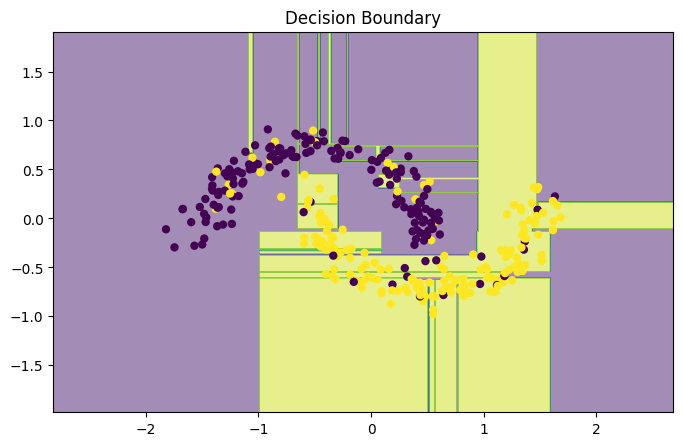

<Figure size 800x494.438 with 0 Axes>

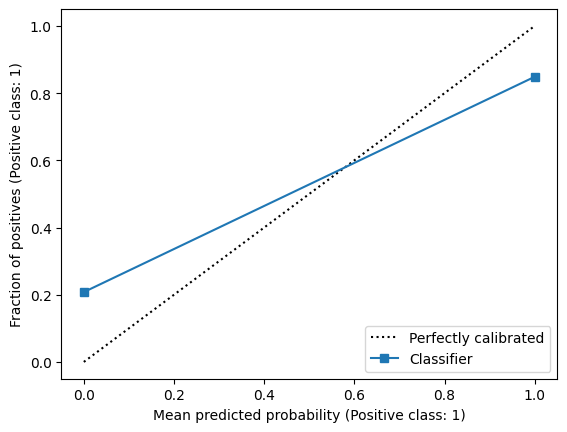

Performance Metrics
--------------------
 Validation Categorical CrossEntropy: 6.332
 Test       Categorical CrossEntropy: 6.553
 Test       Accuracy                : 0.818


In [20]:
evaluate_decision_tree()

## Hyperparameter Optimization

In [25]:
from deephyper.hpo import CBO
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback
from deephyper.evaluator.callback import SearchEarlyStopping


def run_hpo():

    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    problem = create_hpo_problem()

    evaluator = Evaluator.create(
        run,
        method="thread",
        method_kwargs={
            # "num_cpus": 1,
            # "num_cpus_per_task": 1,
            "num_workers": 8,
            "run_function_kwargs": {
                "model_checkpoint_dir": model_checkpoint_dir,
                "verbose": False,
            },
            "callbacks": [
                TqdmCallback(),
                # SearchEarlyStopping(patience=50),
            ]
        },
    )
    search = CBO(
        problem,
        evaluator,
        log_dir=hpo_dir,
        initial_points=[problem.default_configuration],
        n_initial_points=20,
        surrogate_model="ET", # Use Extra Trees as surrogate model
        surrogate_model_kwargs={
            "n_estimators": 25, # Relatively small number of trees in the surrogate to make it "fast"
            "min_samples_split": 8, # Larger number to avoid small leaf nodes (smoothing the response)
        },
        acq_func="UCBd",
        acq_optimizer="mixedga",
        acq_optimizer_freq=1,
        # kappa=1.96,
        kappa=5.0,
        scheduler={"type": "periodic-exp-decay", "period": 50, "kappa_final": 0.0001},
        objective_scaler="identity",
    )

    results = search.search(max_evals=450)

    return search, results

In [26]:
search, results = run_hpo()

  0%|          | 0/450 [00:00<?, ?it/s]

In [27]:
results

,p:criterion,p:dummy,p:max_depth,p:min_samples_leaf,p:min_samples_split,p:min_weight_fraction_leaf,p:splitter,objective,job_id,job_status,m:timestamp_submit,m:test_cce,m:test_acc,m:timestamp_gather
0,gini,0.957056,187,15,7,0.465963,best,-0.491424,5,DONE,0.025282,0.552966,0.757576,0.061907
1,gini,0.500000,1000,1,2,0.000000,best,-6.331993,0,DONE,0.025233,6.007276,0.833333,0.071827
2,gini,0.700644,30,2,13,0.389161,random,-0.693107,4,DONE,0.025275,0.693133,0.503030,0.099946
3,entropy,0.414987,86,10,20,0.148949,best,-0.544693,1,DONE,0.025253,0.521100,0.763636,0.100331
4,gini,0.414398,338,9,16,0.373670,best,-0.511322,7,DONE,0.025295,0.548213,0.760606,0.100486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,entropy,0.343861,742,3,14,0.260678,best,-0.471438,450,DONE,138.791691,0.522736,0.766667,139.022464
452,entropy,0.336098,770,3,14,0.259881,best,-0.471438,451,DONE,138.791714,0.522736,0.766667,139.022559
453,entropy,0.339416,701,3,14,0.260007,best,-0.471438,452,DONE,138.791722,0.522736,0.766667,139.022647
454,entropy,0.391941,742,3,14,0.260413,best,-0.471438,454,DONE,138.791736,0.522736,0.766667,139.022732


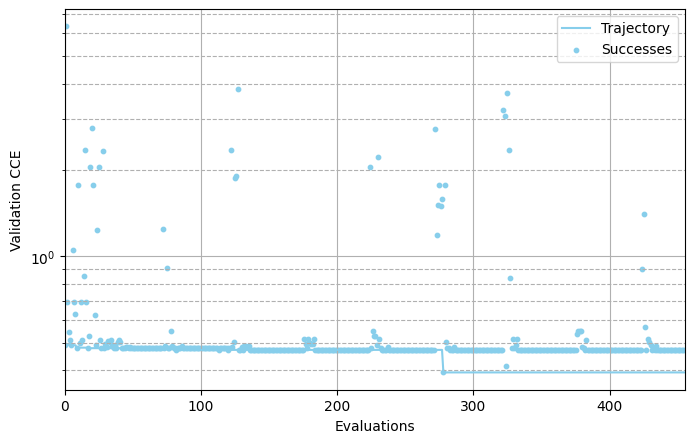

In [28]:
from deephyper.analysis.hpo import plot_search_trajectory_single_objective_hpo

plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plot_search_trajectory_single_objective_hpo(results, mode="min")
plt.yscale("log")
plt.ylabel("Validation CCE")
plt.grid(which="minor", linestyle="--")
plt.show()

## Hyperparameter importance and interactions

To explain the impact of our hyperparameter, we start by loading the surrogate model from the Bayesian optimization and we re-fit it on our target of interest (here the test accuracy as variations in accuracy are easier for interpretation).

Then, we look at the MSE of our surrogate model to evaluate if it is underfitting.

First we look at the hyperparameter importance (based on permutation importance algorithm of the surrogate model).

In [44]:
from sklearn.model_selection import train_test_split


surrogate_model = search.get_surrogate_model()
hyperparameter_names = surrogate_model.hyperparameter_names

X = results[[f"p:{n}" for n in hyperparameter_names]].values
y = results["m:test_acc"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
surrogate_model.fit(X_train, y_train)

topk = results.nlargest(columns=["m:test_acc"], n=1).index.values

mse_train = surrogate_model.evaluate(X_train, y_train)
mse_test = surrogate_model.evaluate(X_test, y_test)

print(f"Training MSE of the Surrogate Model: {mse_train:.3f}")
print(f"Test     MSE of the Surrogate Model: {mse_test:.3f}")

print(f"\nHyperparameter importance:")
hp_imp = surrogate_model.hyperparameter_importance(X, y, n_repeats=20)
important_hyperparameters = []
for hp_name, val in hp_imp.items():
    prefix = ""
    if val['mean'] - 2 * val['std'] > 0:
        prefix = " +++ "
        important_hyperparameters.append(hp_name)
    else:
        prefix = " --- "
    print(f"{prefix}{hp_name}: {val['mean']:.3f} ± {val['std']:.3f}")



Training MSE of the Surrogate Model: 0.000
Test     MSE of the Surrogate Model: 0.000

Hyperparameter importance:
 +++ min_weight_fraction_leaf: 1.408 ± 0.073
 +++ splitter: 1.092 ± 0.097
 +++ criterion: 0.143 ± 0.054
 +++ min_samples_split: 0.016 ± 0.007
 +++ min_samples_leaf: 0.013 ± 0.005
 +++ max_depth: 0.005 ± 0.001
 +++ dummy: 0.004 ± 0.002


The training and test MSE of the surrogate model gives us an idea of the surrogate model underfitting or overfitting the results data. Both of these situations are to checked and avoided. In our case both values are close so it seems okay.

The hyperparameter importance values will give us an idea of how each hyperparameter impacts the quantity of interest (here the test accuracy) globally in our collected results. These quantities are sensitive to the process generating the results (Random search, Bayesian optimization, etc...) and the surrogate model used. They cannot be generalized easily and must be interpreted with caution. 

We sorted the hyperparameter importance values in decreasing order.

We can see that our `dummy` hyperparameter is among the least important ones which is a good sanity check.

An other good sanity check is to see that `max_depth` is not very important. Indeed, the range of `max_depth` is significantly larger than the dataset training set! Making most of this range unimportant. Observing this can help you refine your hyperparameter ranges.

Now that we have a global understanding of hyperparameter sensitivity we can look specificaly at the sensitivity of hyperparameters for the top configurations.

For this we use the `shapiq` package:

```bash
pip install shapiq
```

/Users/romainegele/miniforge3/envs/dh-3.12-240724/lib/python3.12/site-packages/shapiq/explainer/tabular.py:231: UserWarning: `index='SV'` but `max_order != 1`, setting `max_order = 1`. Using the KernelSHAP approximator.
  warnings.warn(
/Users/romainegele/miniforge3/envs/dh-3.12-240724/lib/python3.12/site-packages/shapiq/approximator/sampling.py:427: UserWarning: Not all budget is required due to the border-trick.
  warnings.warn("Not all budget is required due to the border-trick.")


p:criterion                     entropy
p:dummy                        0.019272
p:max_depth                         328
p:min_samples_leaf                    1
p:min_samples_split                  18
p:min_weight_fraction_leaf     0.000391
p:splitter                         best
objective                     -3.839277
job_id                              127
job_status                         DONE
m:timestamp_submit            30.749797
m:test_cce                     3.282651
m:test_acc                     0.875758
m:timestamp_gather            31.815329
Name: 127, dtype: object


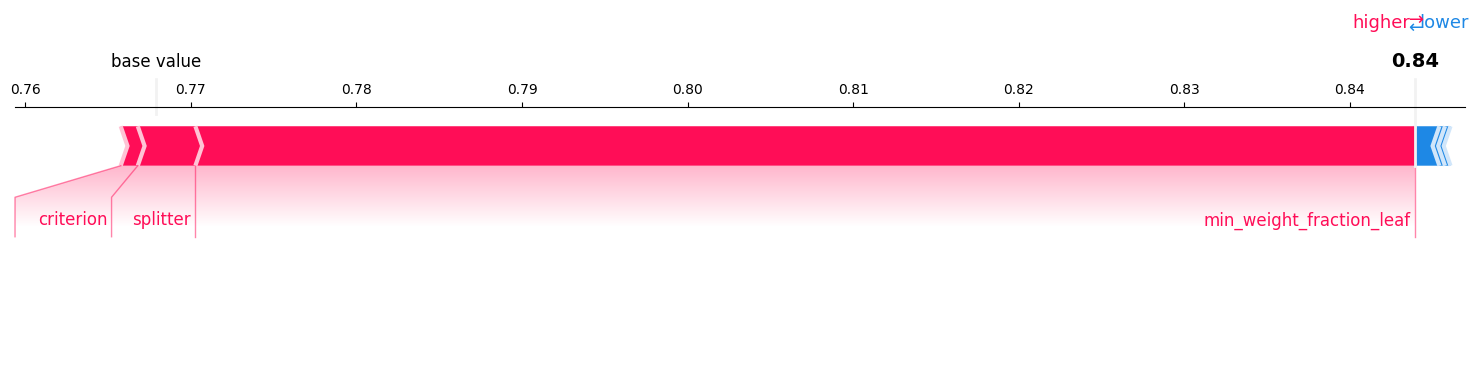

In [56]:
import shapiq

explainer = shapiq.TabularExplainer(
    model=surrogate_model,
    data=X,
    index="SV",  # Shapley values
)
for i in topk:
    print(results.loc[i])
    shapley_values = explainer.explain(X[i], budget=1024)
    shapley_values.plot_force(feature_names=hyperparameter_names, abbreviate=False)

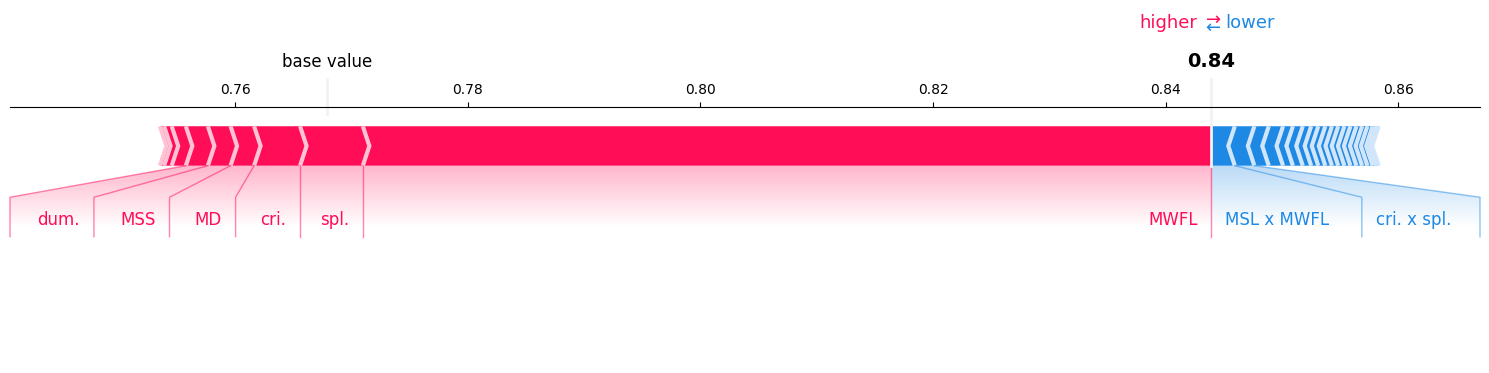

In [66]:
explainer = shapiq.Explainer(
    model=surrogate_model,
    data=X,
    index="k-SII",  # k-SII interaction values
    max_order=2     # specify any order you want
)

for i in topk:
    interaction_values = explainer.explain(X[i])
    interaction_values.plot_force(feature_names=hyperparameter_names, abbreviate=True)

## The Best Decision Tree

In [48]:
from deephyper.analysis.hpo import parameters_from_row

topk_rows = results.nlargest(5, "m:test_acc").reset_index(drop=True)

for i, row in topk_rows.iterrows():
    parameters = parameters_from_row(row)
    value = row["m:test_acc"]
    print(f"Top-{i+1} -> {value=:.3f}: {parameters}")
    print()

Top-1 -> value=0.861: {'criterion': 'entropy', 'max_depth': 625, 'min_samples_leaf': 7, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0503965958980936, 'splitter': 'best'}

Top-2 -> value=0.848: {'criterion': 'log_loss', 'max_depth': 91, 'min_samples_leaf': 1, 'min_samples_split': 14, 'min_weight_fraction_leaf': 0.0045591221518086, 'splitter': 'best'}

Top-3 -> value=0.848: {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 14, 'min_weight_fraction_leaf': 0.0388209394930093, 'splitter': 'best'}

Top-4 -> value=0.848: {'criterion': 'log_loss', 'max_depth': 953, 'min_samples_leaf': 4, 'min_samples_split': 14, 'min_weight_fraction_leaf': 0.0058672088427552, 'splitter': 'best'}

Top-5 -> value=0.830: {'criterion': 'entropy', 'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.0016366535988247, 'splitter': 'best'}



In [49]:
best_job = topk_rows.iloc[0]

hpo_dir = "hpo_sklearn_classification"
model_checkpoint_dir = os.path.join(hpo_dir, "models")

with open(os.path.join(model_checkpoint_dir, f"model_0.{best_job.job_id}.pkl"), "rb") as f:
    best_model = pickle.load(f)

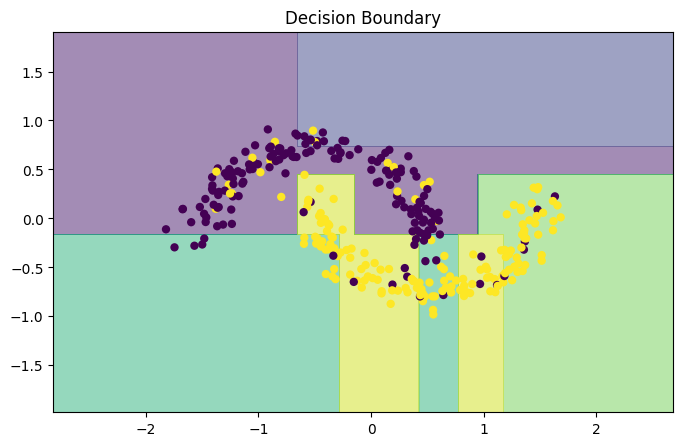

In [51]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plt.title("Decision Boundary")
plot_decision_boundary_decision_tree(
    tx, ty, best_model, steps=1000, color_map="viridis"
)
plt.show()